In [50]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.model_selection import learning_curve

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn.utils import shuffle as shf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [51]:
code = {'NORMAL':0 ,'PNEUMONIA':1}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

trainpath = '../../dataset/train'
validationpath = '../../dataset/val'
testpath = '../../dataset/test'

pixels = 150
img_size = (pixels, pixels)

def resize(path):
    images = []
    labels = []
    for label in os.listdir(path):
        label_dir = os.path.join(path, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            images.append(list(img))            
            labels.append(label)

    return np.array(images), np.array(labels)

X_train = []
y_train = []
X_train, y_train = resize(trainpath)

X_test = []
y_test = []
X_test, y_test = resize(testpath)

X_validation = []
y_validation = []
X_validation, y_validation = resize(validationpath)

print('Train data shape : ', X_train.shape, y_train.shape)
print('Test data shape : ', X_test.shape, y_test.shape)
print('Validation data shape : ', X_validation.shape, y_validation.shape)

Train data shape :  (5216, 150, 150, 3) (5216,)
Test data shape :  (624, 150, 150, 3) (624,)
Validation data shape :  (16, 150, 150, 3) (16,)


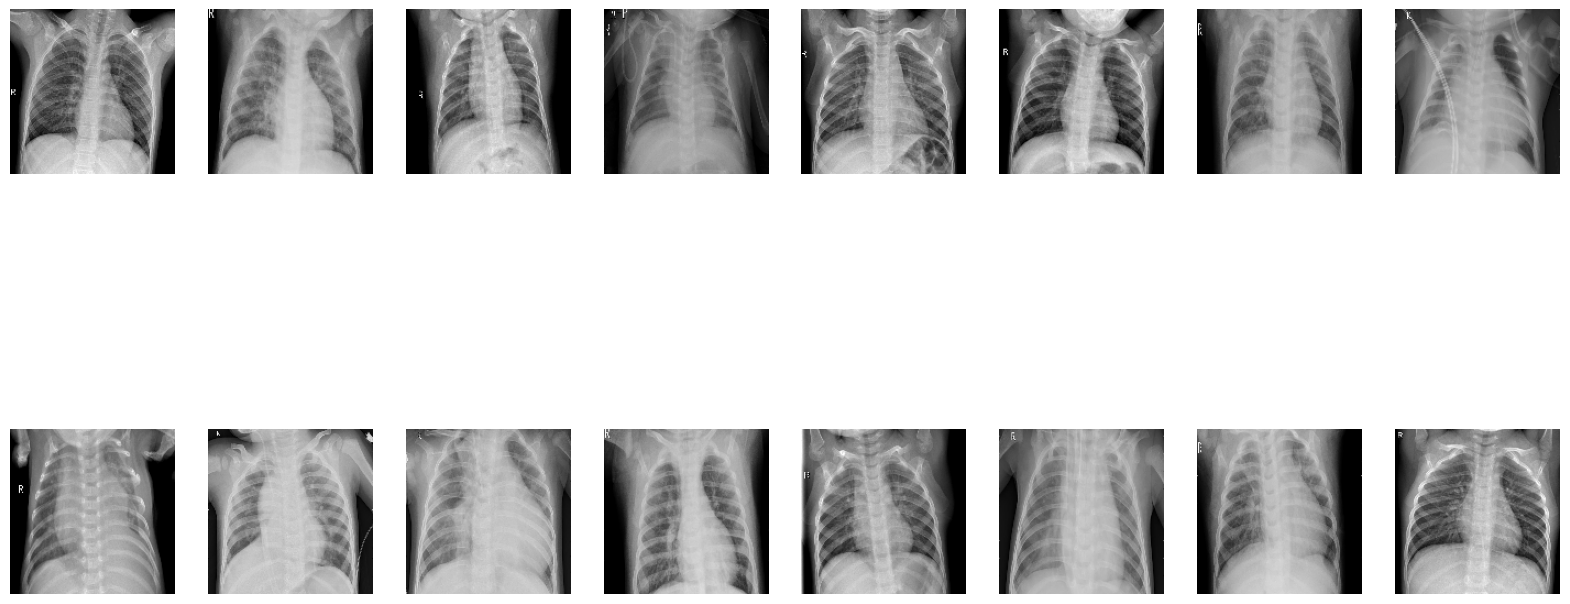

In [52]:
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(X_train),16)): 
    plt.subplot(2,8,n+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(getcode(y_train[i]))

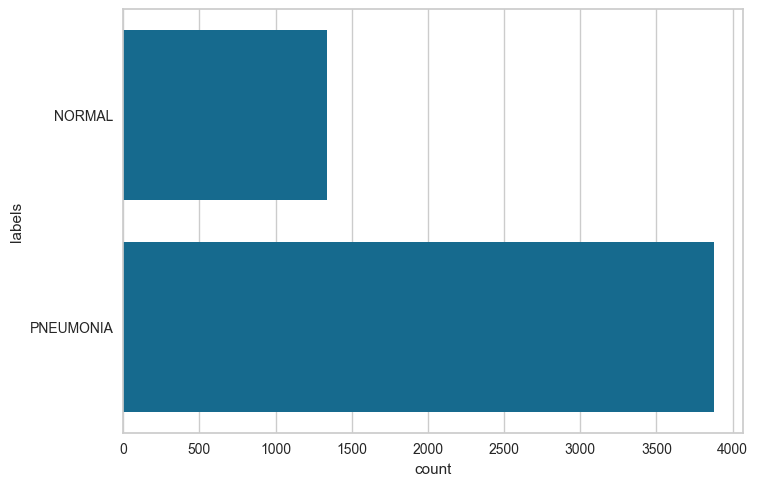

In [53]:
df_train = pd.DataFrame()
df_train["labels"]= y_train
lab = df_train['labels']
dist = lab.value_counts()
sns.countplot(lab)
plt.show()

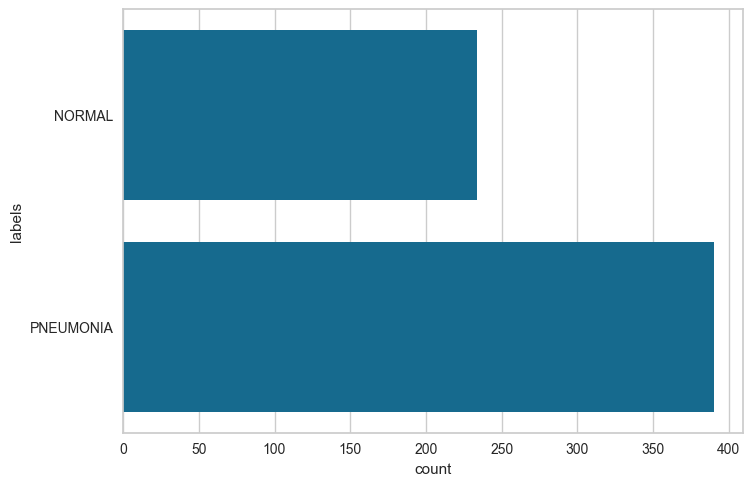

In [54]:
df_test = pd.DataFrame()
df_test["labels"]= y_test
lab = df_test['labels']
dist = lab.value_counts()
sns.countplot(lab)
plt.show()

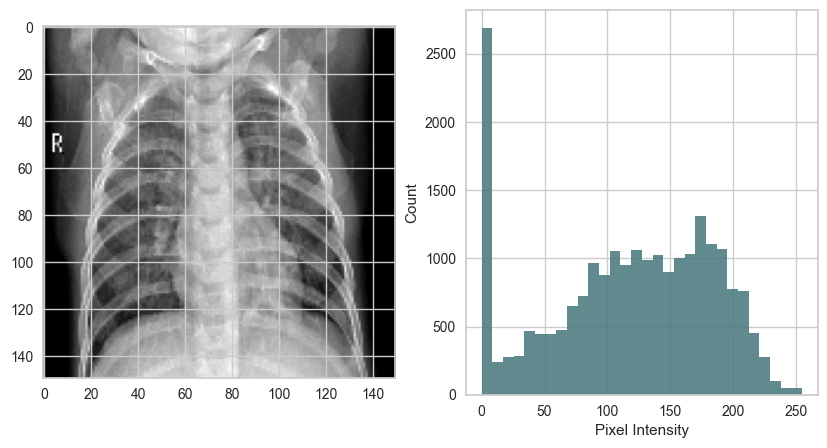

In [55]:
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)

plotHistogram(X_train[np.random.randint(len(X_train))])

In [56]:
X_train = X_train.reshape([-1, np.prod((pixels,pixels,3))])
X_test = X_test.reshape([-1, np.prod((pixels,pixels,3))])

print(X_train.shape)
print(X_test.shape)

(5216, 67500)
(624, 67500)


In [57]:
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

In [58]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
print('Accuracy score is: ' + str(knn.score(X_test, y_test)))

Accuracy score is: 0.7355769230769231


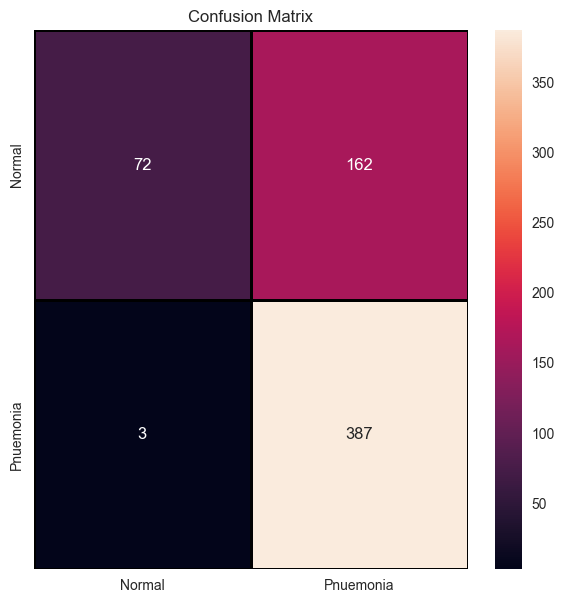

In [59]:
knn_predcited = knn.predict(X_test)

def plot_cm(predictions, y_test, title):
  labels = ['Normal', 'Pnuemonia']
  cm = confusion_matrix(y_test,predictions)
  cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
  plt.figure(figsize = (7,7))
  plt.title(title)
  sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
  plt.show()


plot_cm(knn_predcited, y_test, 'Confusion Matrix')

In [60]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print('Number of components after PCA: ' + str(pca.n_components_))

Number of components after PCA: 635


In [61]:
knn_PCA = KNeighborsClassifier(n_neighbors=10)
knn_PCA.fit(X_train, y_train)
print('KNN accuracy score is: ' + str(knn_PCA.score(X_test, y_test)))

KNN accuracy score is: 0.7580128205128205


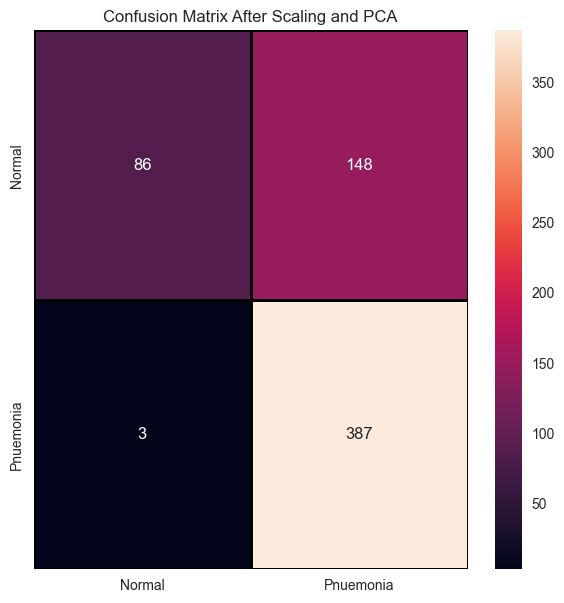

In [62]:
knn_PCA_predcited = knn_PCA.predict(X_test)
plot_cm(knn_PCA_predcited, y_test, 'Confusion Matrix After Scaling and PCA')

In [63]:
smote = SMOTE(random_state = 11)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(7750, 635)
(7750,)


In [64]:
knn_smote = KNeighborsClassifier(n_neighbors=10)
knn_smote.fit(X_train_smote, y_train_smote)
print('Accuracy score is: ' + str(knn_smote.score(X_test, y_test)))

Accuracy score is: 0.8157051282051282


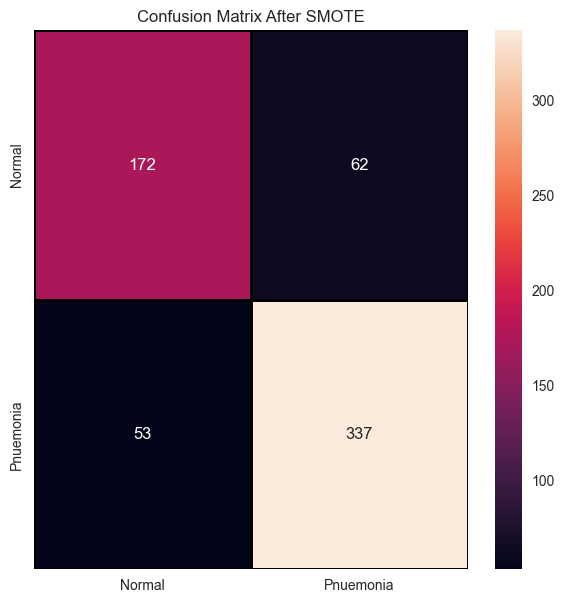

In [65]:
knn_smote_predcited = knn_smote.predict(X_test)
plot_cm(knn_smote_predcited, y_test, 'Confusion Matrix After SMOTE')

In [66]:
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_smote_tomek, y_smote_tomek= resample.fit_resample(X_train, y_train)
print(X_smote_tomek.shape)
print(y_smote_tomek.shape)

(7749, 635)
(7749,)


In [67]:
knn_smote_tomek = KNeighborsClassifier(n_neighbors=10)
knn_smote_tomek.fit(X_smote_tomek, y_smote_tomek)
print('Accuracy score is: ' + str(knn_smote_tomek.score(X_test, y_test)))

Accuracy score is: 0.8365384615384616


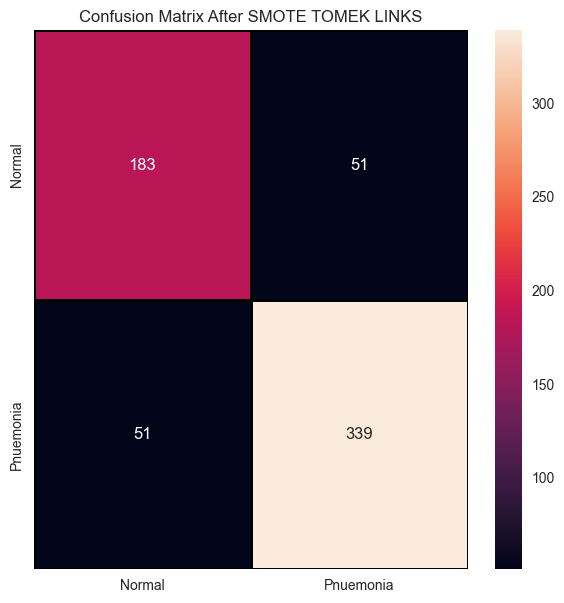

In [68]:
knn_smote_tomek_predcited = knn_smote_tomek.predict(X_test)
plot_cm(knn_smote_tomek_predcited, y_test, 'Confusion Matrix After SMOTE TOMEK LINKS')

In [69]:
print(classification_report(y_test, knn_smote_tomek_predcited, target_names= ['Normal (0)', 'Pneumonia (1)']))

Prediction score :  ['PNEUMONIA' 'NORMAL' 'PNEUMONIA' 'NORMAL' 'PNEUMONIA' 'PNEUMONIA'
 'NORMAL' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA'
 'PNEUMONIA' 'NORMAL' 'PNEUMONIA' 'PNEUMONIA' 'NORMAL' 'PNEUMONIA'
 'PNEUMONIA' 'PNEUMONIA' 'NORMAL' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA'
 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA'
 'PNEUMONIA' 'NORMAL' 'PNEUMONIA' 'PNEUMONIA' 'NORMAL' 'PNEUMONIA'
 'PNEUMONIA' 'PNEUMONIA' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'PNEUMONIA'
 'PNEUMONIA' 'NORMAL' 'NORMAL' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA'
 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA'
 'PNEUMONIA' 'NORMAL' 'NORMAL' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA'
 'NORMAL' 'PNEUMONIA' 'PNEUMONIA' 'NORMAL' 'NORMAL' 'PNEUMONIA' 'NORMAL'
 'PNEUMONIA' 'NORMAL' 'PNEUMONIA' 'NORMAL' 'NORMAL' 'PNEUMONIA'
 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'NORMAL' 'PNEUMONIA'
 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'NORMAL' 'PNEUMONIA' 'PNEUMONIA'
 'PNEUMON

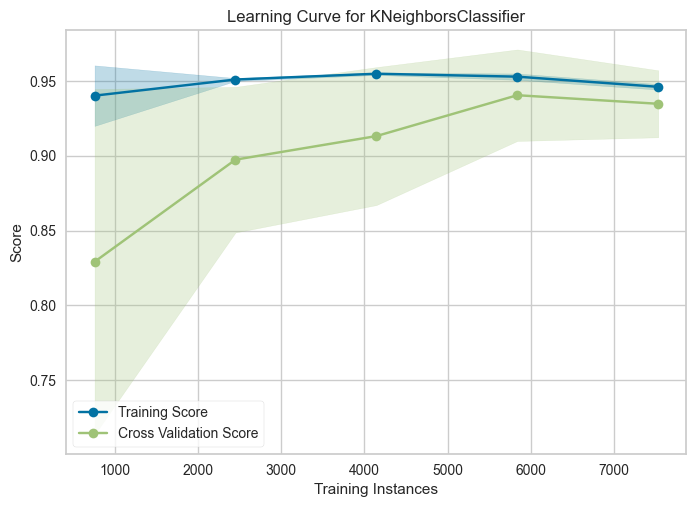

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [70]:
X = np.concatenate((X_smote_tomek, X_test))
y = np.concatenate((y_smote_tomek, y_test))

print(learning_curve(knn_smote_tomek, X, y, cv=10, scoring='accuracy'))